# Covid Research 20201109

***
## 0. Import

In [1]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot

from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder

***
## 1. Read Data

In [2]:
df = pd.read_excel('ed_pred.xlsx')
df = df.reset_index()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 41 columns):
index                       7380 non-null int64
patno                       7380 non-null int64
Admitted                    7380 non-null int64
AdmittingDepartment         3003 non-null object
COVIDResult                 7380 non-null object
Age                         7380 non-null int64
FirstRace                   7379 non-null object
Ethnicity                   7380 non-null object
Sex                         7380 non-null object
heart_rate                  7352 non-null float64
sbp                         7292 non-null float64
dbp                         7292 non-null float64
pulse_ox                    7346 non-null float64
resp_rate                   7312 non-null float64
height                      456 non-null float64
wght                        3248 non-null float64
cbc_wbc                     6256 non-null float64
cbc_hematocrit              6256 non-null float64
cbc_hem

In [4]:
df.describe()

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cbc_monocyte_c,cbc_eosinophil_perc.2,cmp_sodium,cmp_potassium,cmp_chloride,cmp_glucose,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin
count,7380.000000,7380.000000,7380.000000,7380.000000,7352.000000,7292.000000,7292.000000,7346.000000,7312.000000,456.000000,...,3874.000000,3872.000000,6286.000000,5570.000000,6286.000000,6286.000000,4767.000000,5399.000000,5175.000000,5402.000000
mean,3689.500000,3690.500000,0.406911,48.977642,94.529788,135.998354,76.034696,97.064661,21.029130,65.971491,...,0.740428,1.492485,137.104677,4.043447,102.562997,137.406141,55.627858,114.154843,7.210473,3.846113
std,2130.566826,2130.566826,0.491291,23.525661,23.352438,27.256409,15.302797,3.832935,6.762566,7.635750,...,0.545253,2.276703,4.366669,0.603037,5.600923,92.857337,154.142598,89.983238,0.843891,0.577974
min,0.000000,1.000000,0.000000,0.000000,0.000000,46.000000,0.000000,25.000000,0.000000,2.000000,...,0.000000,0.000000,107.000000,2.000000,60.000000,22.000000,7.000000,21.000000,2.400000,1.000000
25%,1844.750000,1845.750000,0.000000,31.000000,78.000000,118.000000,65.000000,96.000000,18.000000,63.000000,...,0.460000,0.100000,135.000000,3.700000,100.000000,94.000000,23.000000,71.000000,6.700000,3.500000
50%,3689.500000,3690.500000,0.000000,52.000000,92.000000,133.000000,75.000000,98.000000,20.000000,67.000000,...,0.670000,0.800000,138.000000,4.000000,103.000000,109.000000,31.000000,90.000000,7.200000,3.900000
75%,5534.250000,5535.250000,1.000000,67.000000,107.000000,151.000000,86.000000,99.000000,22.000000,70.000000,...,0.940000,2.000000,140.000000,4.300000,106.000000,140.000000,46.000000,123.000000,7.700000,4.200000
max,7379.000000,7380.000000,1.000000,119.000000,235.000000,258.000000,147.000000,100.000000,111.000000,77.000000,...,17.790000,41.100000,182.000000,8.900000,143.000000,1576.000000,6479.000000,1126.000000,11.300000,6.300000


In [5]:
df.corr()

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cbc_monocyte_c,cbc_eosinophil_perc.2,cmp_sodium,cmp_potassium,cmp_chloride,cmp_glucose,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin
index,1.000000,1.000000,-0.030377,-0.071132,-0.014543,-0.013479,-0.002088,0.066634,-0.031710,-0.017314,...,0.006011,0.000322,0.039232,-0.005859,0.026758,-0.010492,-0.036648,-0.011070,0.016393,0.045855
patno,1.000000,1.000000,-0.030377,-0.071132,-0.014543,-0.013479,-0.002088,0.066634,-0.031710,-0.017314,...,0.006011,0.000322,0.039232,-0.005859,0.026758,-0.010492,-0.036648,-0.011070,0.016393,0.045855
Admitted,-0.030377,-0.030377,1.000000,0.259000,0.071533,-0.034520,-0.083964,-0.187805,0.141345,0.006556,...,0.090950,-0.122416,-0.139857,0.123330,-0.145144,0.125331,0.098732,0.117501,-0.169298,-0.301735
Age,-0.071132,-0.071132,0.259000,1.000000,-0.343054,0.255632,0.021500,-0.233759,-0.128765,0.237857,...,-0.068070,-0.003148,-0.077553,0.129890,-0.137116,0.097948,-0.014016,-0.091849,-0.147716,-0.312481
heart_rate,-0.014543,-0.014543,0.071533,-0.343054,1.000000,-0.128325,0.032385,-0.018398,0.397967,-0.277916,...,0.100502,-0.102094,-0.062122,-0.048065,-0.073826,0.074114,0.025044,0.123586,0.046071,0.021046
sbp,-0.013479,-0.013479,-0.034520,0.255632,-0.128325,1.000000,0.700990,0.012399,-0.054224,0.129512,...,-0.037211,0.056011,0.089829,-0.016583,0.003022,0.052785,-0.058817,-0.102502,0.195652,0.193473
dbp,-0.002088,-0.002088,-0.083964,0.021500,0.032385,0.700990,1.000000,0.044760,-0.038692,0.178501,...,-0.019228,0.026571,0.119920,-0.055991,0.036059,0.017755,-0.010922,-0.091883,0.268447,0.288271
pulse_ox,0.066634,0.066634,-0.187805,-0.233759,-0.018398,0.012399,0.044760,1.000000,-0.203094,0.003070,...,-0.002565,0.017027,0.012110,-0.118440,0.099202,-0.105208,-0.052456,-0.005379,0.037321,0.123265
resp_rate,-0.031710,-0.031710,0.141345,-0.128765,0.397967,-0.054224,-0.038692,-0.203094,1.000000,-0.339655,...,0.078115,-0.037053,-0.013692,0.118477,-0.008239,0.076232,0.037055,0.099776,-0.078270,-0.083926
height,-0.017314,-0.017314,0.006556,0.237857,-0.277916,0.129512,0.178501,0.003070,-0.339655,1.000000,...,-0.033168,-0.156211,0.055314,-0.173582,0.030194,0.057657,0.005574,-0.187236,0.127008,0.030490


In [6]:
detected_count = 0
non_detected_count = 0
invalid_count = 0
for i in df[['COVIDResult']].values:
    if i == "Detected":
        detected_count += 1
    elif i == "None Detected":
        non_detected_count += 1
    else:
        invalid_count += 1

total_count = detected_count + non_detected_count + invalid_count 
print("Detected:\t{},\t{:.2f}%".format(detected_count, detected_count * 100.0 / total_count))
print("None Detected:\t{},\t{:.2f}%".format(non_detected_count, non_detected_count * 100.0 / total_count))
print("Invalid Data:\t{},\t{:.2f}%".format(invalid_count, invalid_count * 100.0 / total_count))

Detected:	470,	6.37%
None Detected:	6910,	93.63%
Invalid Data:	0,	0.00%


***
## 2. Preprocess

In [7]:
def numerical_preprocess(x_num):
    for i in range(len(x_num)):
        for j in range(len(x_num[i])):
            if isinstance(x_num[i][j], str):
                if (ord('0') <= ord(x_num[i][j][0]) <= ord('9')):
                    x_num[i][j] = float(x_num[i][j])
                else:
                    x_num[i][j] = float(x_num[i][j][1:])
                    
    imp = SimpleImputer()
    x_num = imp.fit_transform(x_num)
    
#     scaler = StandardScaler()
#     x_num = scaler.fit_transform(x_num)
    
    return x_num
    
def categorical_preprocess(x_cat):
    for i in range(len(x_cat)):
        if not isinstance(x_cat[i][0], str):
            x_cat[i][0] = 'NA'
        if not isinstance(x_cat[i][1], str):
            x_cat[i][1] = '*Unspecified'
            
    oe = OrdinalEncoder()
    x_cat = oe.fit_transform(x_cat)
    
    return x_cat
    
def y_preprocess(y):
    le = LabelEncoder()
    y = le.fit_transform(y)
    for i in range(len(y)):
        y[i] = 1 - y[i]
    
    return y

def preprocess(data):
    data = data.drop(['index', 'patno'], axis=1)
    
    x_num = data.drop(['AdmittingDepartment', 'COVIDResult', 'FirstRace', 'Ethnicity', 'Sex'], axis=1).values
    x_cat = data[['AdmittingDepartment', 'FirstRace', 'Ethnicity', 'Sex']].values
     
    x_num = numerical_preprocess(x_num)
    x_cat = categorical_preprocess(x_cat)
    
    x = np.concatenate((x_num, x_cat), axis=1)
    y = y_preprocess(data[['COVIDResult']].values.ravel())
    
    return x, y

train, test = train_test_split(df, test_size = 0.2)
x_train, y_train = preprocess(train)
x_test, y_test = preprocess(test)

***
## 3. Logistic Regression

In [8]:
def evaluation(y_test, y_pred):
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
    print("Precision: {:.2f}%".format(precision_score(y_test, y_pred) * 100))
    print("Recall: {:.2f}%".format(recall_score(y_test, y_pred) * 100))
    print("F1 score: {:.2f}%".format(f1_score(y_test, y_pred) * 100))

lr = LogisticRegression(solver='liblinear')
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
evaluation(y_test, y_pred)

Confusion matrix:
[[1221  161]
 [  38   56]]
Accuracy: 86.52%
Precision: 25.81%
Recall: 59.57%
F1 score: 36.01%


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


***
## 4. Feature Selection

### 4.1 Chi-square Test

In [9]:
col = df.columns
col = col.drop(['index', 'patno', 'AdmittingDepartment', 'COVIDResult', 'FirstRace', 'Ethnicity', 'Sex'])
col = col.append(pd.Index(['AdmittingDepartment', 'FirstRace', 'Ethnicity', 'Sex']))

fs = SelectKBest(score_func=chi2, k='all')
fs.fit(x_train, y_train)

scores = {}
for i in range(len(fs.scores_)):
    scores[(i, col[i])] = fs.scores_[i]
    
scores = sorted(scores.items(), key=lambda x : x[1], reverse=True)
for i in scores:
    print('Feature %d %s: %f' % (i[0][0], i[0][1], i[1]))

Feature 12 cbc_platelets: 656.006312
Feature 30 cmp_alkaline_phosphatase: 439.606912
Feature 34 AdmittingDepartment: 325.919585
Feature 9 cbc_wbc: 189.232923
Feature 13 cbc_neutrophil_c: 80.267420
Feature 35 FirstRace: 76.110317
Feature 27 cmp_glucose: 70.426305
Feature 1 Age: 59.258177
Feature 25 cmp_bun: 46.463119
Feature 18 cbc_eosinophil_perc.1: 37.870783
Feature 14 cbc_eosinophil_perc: 37.870783
Feature 20 cbc_eosinophil_perc.2: 37.870783
Feature 29 cmp_ast: 29.331370
Feature 2 heart_rate: 26.723833
Feature 3 sbp: 22.363338
Feature 8 wght: 22.076937
Feature 36 Ethnicity: 19.100133
Feature 0 Admitted: 11.910683
Feature 16 cbc_lymphocyte_perc: 11.326269
Feature 33 cmp_bilirubin: 9.620650
Feature 15 cbc_lymphocyte_c: 9.221991
Feature 19 cbc_monocyte_c: 6.317391
Feature 10 cbc_hematocrit: 5.715906
Feature 6 resp_rate: 4.834543
Feature 28 cmp_alt: 4.794444
Feature 17 cbc_eosinophil_c: 4.727201
Feature 5 pulse_ox: 3.474062
Feature 11 cbc_hemoglobin: 2.883937
Feature 26 cmp_creatinine: 1

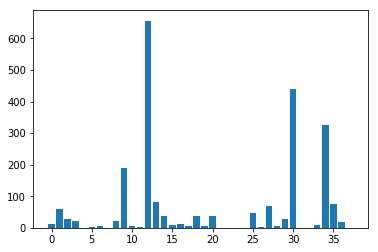

In [10]:
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

***
## 5. Logistic Regression on Selected Feature

### 5.0 Setup

In [11]:
idx = []
for i in scores:
    idx.append(i[0][0])

### 5.1 Top 10 Features

In [12]:
x_train_10 = x_train[:, idx[:10]]
x_test_10 = x_test[:, idx[:10]]

lr = LogisticRegression(solver='liblinear')
lr.fit(x_train_10, y_train)
y_pred_10 = lr.predict(x_test_10)
evaluation(y_test, y_pred_10)

Confusion matrix:
[[1382    0]
 [  94    0]]
Accuracy: 93.63%
Precision: 0.00%
Recall: 0.00%
F1 score: 0.00%


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5.2 Top 20 Features

In [13]:
x_train_20 = x_train[:, idx[:20]]
x_test_20 = x_test[:, idx[:20]]

lr = LogisticRegression(solver='liblinear')
lr.fit(x_train_20, y_train)
y_pred_20 = lr.predict(x_test_20)
evaluation(y_test, y_pred_20)

Confusion matrix:
[[1293   89]
 [  51   43]]
Accuracy: 90.51%
Precision: 32.58%
Recall: 45.74%
F1 score: 38.05%


### 5.3 Top 30 Features

In [14]:
x_train_30 = x_train[:, idx[:30]]
x_test_30 = x_test[:, idx[:30]]

lr = LogisticRegression(solver='liblinear')
lr.fit(x_train_30, y_train)
y_pred_30 = lr.predict(x_test_30)
evaluation(y_test, y_pred_30)

Confusion matrix:
[[1219  163]
 [  40   54]]
Accuracy: 86.25%
Precision: 24.88%
Recall: 57.45%
F1 score: 34.73%


---
## 6. Bagging

### 6.1 Bagging Classifier with Logistic Regression

In [15]:
clf = BaggingClassifier(base_estimator=LogisticRegression(solver='liblinear'))
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
evaluation(y_test, y_pred)

Confusion matrix:
[[1171  211]
 [  34   60]]
Accuracy: 83.40%
Precision: 22.14%
Recall: 63.83%
F1 score: 32.88%


### 6.2 Balanced Bagging Classifier with Logistic Regression

In [17]:
bbc = BalancedBaggingClassifier(base_estimator=LogisticRegression(solver='liblinear'),
                                sampling_strategy='auto',
                                replacement=FalseΩΩΩΩΩΩΩΩ¸¸¸Ω,
                                random_state=0)
bbc.fit(x_train, y_train)
y_pred = bbc.predict(x_test)
evaluation(y_test, y_pred)

Confusion matrix:
[[ 225 1157]
 [   7   87]]
Accuracy: 21.14%
Precision: 6.99%
Recall: 92.55%
F1 score: 13.00%
